In [2]:
%load_ext autoreload
%autoreload 2
import torch
import h5py as h5
import matplotlib.pyplot as plt
import os
import configparser
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
from get_survival_from_shot import get_rt_survival_from_shot, get_cakenn_survival_from_shot
import metrics_helpers
import plotting_helpers
import seaborn as sns

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For main model:
AUROC = 0.846
At threshold 0.1, FPR = 0.274, TPR = 0.816 and warning time = 1.1e+03
At threshold 0.2, FPR = 0.124, TPR = 0.563 and warning time = 760
At threshold 0.3, FPR = 0.0665, TPR = 0.32 and warning time = 550
For secondary model:
AUROC = 0.817
At threshold 0.1, FPR = 0.299, TPR = 0.795 and warning time = 920
At threshold 0.2, FPR = 0.0851, TPR = 0.373 and warning time = 480
At threshold 0.3, FPR = 0.00136, TPR = 0.00493 and warning time = 230


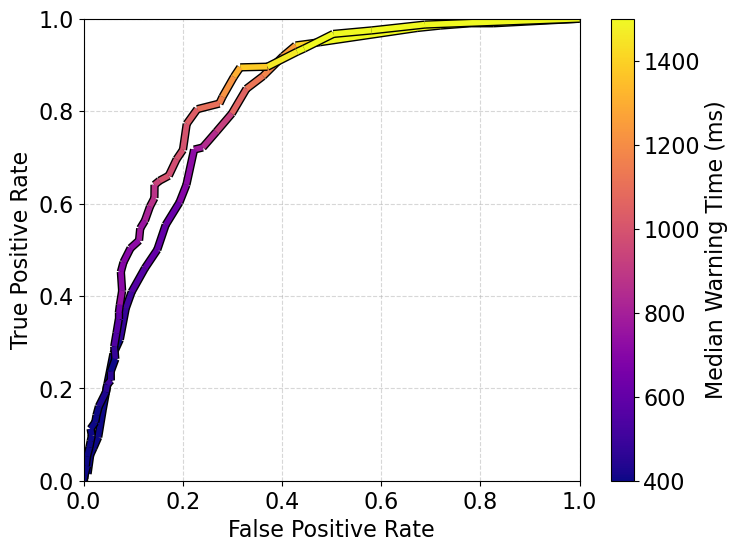

In [8]:
with open('figure_data/model_25_roc_data.pkl', 'rb') as f:
    main_roc_data = pickle.load(f)
main_fprs, main_tprs, main_warning_times = main_roc_data['fprs'], main_roc_data['tprs'], main_roc_data['median_warning_times']
print('For main model:')
print(f'AUROC = {metrics_helpers.get_auc(main_fprs, main_tprs):.3g}')
print(f'At threshold 0.1, FPR = {main_fprs[10]:.3g}, TPR = {main_tprs[10]:.3g} and warning time = {main_warning_times[10]:.3g}')
print(f'At threshold 0.2, FPR = {main_fprs[20]:.3g}, TPR = {main_tprs[20]:.3g} and warning time = {main_warning_times[20]:.3g}')
print(f'At threshold 0.3, FPR = {main_fprs[30]:.3g}, TPR = {main_tprs[30]:.3g} and warning time = {main_warning_times[30]:.3g}')

with open('figure_data/model_23_roc_data.pkl', 'rb') as f:
    secondary_roc_data = pickle.load(f)
secondary_fprs, secondary_tprs, secondary_warning_times = secondary_roc_data['fprs'], secondary_roc_data['tprs'], secondary_roc_data['median_warning_times']
print('For secondary model:')
print(f'AUROC = {metrics_helpers.get_auc(secondary_fprs, secondary_tprs):.3g}')
print(f'At threshold 0.1, FPR = {secondary_fprs[10]:.3g}, TPR = {secondary_tprs[10]:.3g} and warning time = {secondary_warning_times[10]:.3g}')
print(f'At threshold 0.2, FPR = {secondary_fprs[20]:.3g}, TPR = {secondary_tprs[20]:.3g} and warning time = {secondary_warning_times[20]:.3g}')
print(f'At threshold 0.3, FPR = {secondary_fprs[30]:.3g}, TPR = {secondary_tprs[30]:.3g} and warning time = {secondary_warning_times[30]:.3g}')
plotting_helpers.plot_two_roc_curves(secondary_fprs, secondary_tprs, secondary_warning_times, main_fprs, main_tprs, main_warning_times,save_name='AUROC_2')
#plotting_helpers.plot_fpr_tpr_warning_time(main-fprs, tprs, warning_times, save_name='AUROC')

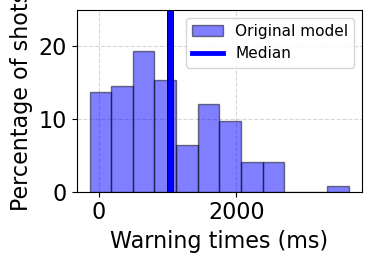

In [140]:
# with open('figure_data/extra_main_model_roc_data.pkl', 'rb') as f:
#     extra_main_model_roc_data = pickle.load(f)
# with open('figure_data/extra_secondary_model_roc_data.pkl', 'rb') as f:
#     extra_secondary_roc_data = pickle.load(f)
with open('figure_data/model_25_warning_times_list.pkl', 'rb') as f:
    main_warning_times_list = pickle.load(f)
with open('figure_data/model_23_warning_times_list.pkl', 'rb') as f:
    secondary_warning_times_list = pickle.load(f)
#main_warning_times_list = extra_main_model_roc_data['warning_times']
#secondary_warning_times_list = extra_secondary_roc_data['warning_times']

#wanted_index = 20
main_warning_times_nonan = [wt for wt in main_warning_times_list[10] if wt is not None]
secondary_warning_times_nonan = [wt for wt in secondary_warning_times_list[12] if wt is not None]

plt.figure(figsize=(4, 3))
plt.rcParams.update({'font.size': 16})
# make histogram with percentage of total

# Set number of bins
bins = 12

# Get bin counts (without density) and shared bin edges
counts1, bin_edges = np.histogram(main_warning_times_nonan, bins=bins, density=False)
counts2, _ = np.histogram(secondary_warning_times_nonan, bins=bin_edges, density=False)

# Convert counts to percentages
counts1_percent = counts1 / counts1.sum() * 100
counts2_percent = counts2 / counts2.sum() * 100

# Compute bin widths and centers
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = bin_edges[:-1]

# Plot as bar charts
plt.bar(bin_centers, counts1_percent, width=bin_width, alpha=0.5, label='Original model', color='blue', edgecolor='black')
#plt.bar(bin_centers, counts2_percent, width=bin_width, alpha=0.5, label='Profiles-only model', color='red', edgecolor='black')

# Labels and formatting
plt.xlabel("Warning times (ms)")
plt.ylabel("Percentage of shots")
plt.axvline(np.median(main_warning_times_nonan), color='black', linewidth=5)
#plt.axvline(np.median(secondary_warning_times_nonan), color='black', linewidth=5)
plt.axvline(np.median(main_warning_times_nonan), color='blue', linewidth=3.5, label='Median')
#plt.axvline(np.median(secondary_warning_times_nonan), color='red', linewidth=3.5, label='Median')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_axisbelow(True)
plt.ylim(0, 25)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
# Reorder them as you wish
order = [1, 0]  # reverse order, for example
plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=11)

#plt.legend(fontsize=11)
#plt.hist(main_warning_times_nonan, bins=15, alpha=0.5, label='Original model', color='blue', linewidth=2, density=True)
#plt.hist(secondary_warning_times_nonan, bins=15, alpha=0.5, label='Profiles-only model', color='red', linewidth=2, density=True)

# # Add legend and labels

# plt.xlabel('Warning Time (ms)')
# plt.ylabel('Percentage of shots')
# #plt.title('Overlapping Histograms (Step Plot)')
# # light blue vertical line
# plt.axvline(np.median(main_warning_times_nonan), color='black', linewidth=5)
# plt.axvline(np.median(secondary_warning_times_nonan), color='black', linewidth=5)
# plt.axvline(np.median(main_warning_times_nonan), color='blue', linewidth=3.5, label='Original Model Median')
# plt.axvline(np.median(secondary_warning_times_nonan), color='red', linewidth=3.5, label='Profiles-only Model Median')

#plt.savefig('plots/warning_time_histogram_full.pdf', bbox_inches='tight')


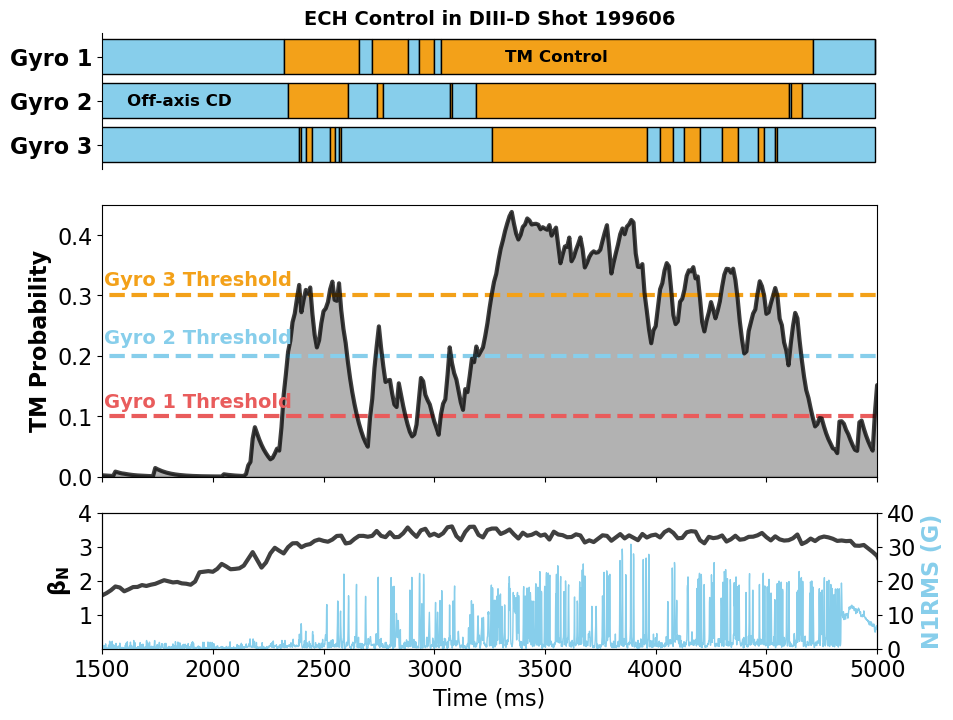

In [141]:
prediction = 2400
onset = 2850

with open('figure_data/199606_rms.pkl', 'rb') as f:
    rms = pickle.load(f)

fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 4, 2]}, figsize=(10, 8))
n1rms = 2
tearability = 1

colors = ['#f3a119', '#87ceeb']
bar_colors = ['#f3a119', '#87ceeb']

heights = [350, 460-350, 540-460, 660-540, 710-660, 2320-710, 2660-2320, 2720-2660, 2880-2720, 2930-2880, 3000-2930, 3030-3000, 4710-3030, 4990-4710, 5030-4990]
left = 0
# Create each bar on the same y-position
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(0, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]

left = 0
# [ 310. 2340. 2610. 2740. 2770. 3070. 3080. 3190. 4600. 4610. 4660.]
heights = [310, 2340-310, 2610-2340, 2740-2610, 2770-2740, 3070-2770, 3080-3070, 3190-3080, 4600-3190, 4610-4600, 4660-4610, 5030-4660]
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(-1, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]

left = 0
# [ 280. 2390. 2400. 2420. 2450. 2530. 2550. 2570. 2580. 3260. 3960. 4020. 4080. 4130. 4200. 4300. 4370. 4460. 4490. 4540. 4550.]
heights = [280, 2390-280, 2400-2390, 2420-2400, 2450-2420, 2530-2450, 2550-2530, 2570-2550, 2580-2570, 3260-2580, 3960-3260, 4020-3960, 4080-4020, 4130-4080, 4200-4130, 4300-4200, 4370-4300, 4460-4370, 4490-4460, 4540-4490, 4550-4540, 5030-4550]
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(-2, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]
axs[0].set_yticks([0, -1, -2])
axs[0].set_yticklabels(['Gyro 1', 'Gyro 2', 'Gyro 3'], fontweight='bold')

axs[0].text(1850, -1, 'Off-axis CD', ha='center', va='center', fontsize=12, fontweight='bold')
axs[0].text(3550, 0, 'TM Control', ha='center', va='center', fontsize=12, fontweight='bold')


axs[n1rms].plot(rms['betan']['times'], rms['betan']['data'], label=r'$\beta_N$', color='black', alpha=0.75, linewidth=3) # colors[3])
axs[n1rms].set_ylabel(r'$\mathbf{\beta_N}$', color='black', fontweight='bold')
axs[n1rms].set_yticks([1, 2, 3, 4])
axs[n1rms].set_ylim([0, 4])
# axs[n1rms].plot(qmin['times'][:], qmin['199607']['qmin_EFIT02ER'][:], label='qmin', color=colors[0])
# axs[n1rms].legend(loc=(0,0.52))
axs2 = axs[n1rms].twinx()
axs2.plot(rms['N1RMS']['times'], rms['N1RMS']['data'], label='N1RMS', color=colors[1], linewidth=1)
axs2.set_ylabel('N1RMS (G)', color=colors[1], fontweight='bold')
axs2.set_yticks([0, 10, 20, 30, 40])
axs2.set_ylim([0, 40])
axs2.tick_params(axis='y')
axs2.grid(False)

axs[tearability].set_ylabel('TM Probability', fontweight='bold', )
axs[tearability].plot([0,5000], [0.1,0.1], '--', label='Threshold 1', color='#e95c5c', linewidth=3)
axs[tearability].plot([0,5000], [0.2,0.2], '--', label='Threshold 2', color='#87ceeb', linewidth=3)
axs[tearability].plot([0,5000], [0.3,0.3], '--', label='Threshold 3', color='#f3a119', linewidth=3)
axs[tearability].plot(rms['TPSSURVIVE']['times'], 1-rms['TPSSURVIVE']['data'], color='black', linewidth=3, alpha=0.75,) # colors[0])
axs[tearability].fill_between(rms['TPSSURVIVE']['times'], 1-rms['TPSSURVIVE']['data'], color='black', alpha=0.3) # Fill under the line

# axs[tearability].legend()

plt.text(1510, 71, 'Gyro 1 Threshold', fontsize=14, fontweight='bold', color='#e95c5c')
plt.text(1510, 90, 'Gyro 2 Threshold', fontsize=14, fontweight='bold', color='#87ceeb')
plt.text(1510, 107, 'Gyro 3 Threshold', fontsize=14, fontweight='bold', color='#f3a119')

axs[tearability].set_ylim([0.,0.45])
axs[tearability].set_xlim([1500,5000])
axs[n1rms].set_xlabel('Time (ms)')
axs[0].set_title('ECH Control in DIII-D Shot 199606', fontweight='bold', fontsize=14)


#plt.text(1525, 173, '(a)', fontsize=12, fontweight='bold')
#plt.text(1525, 125, '(b)', fontsize=12, fontweight='bold')
#plt.text(1525, 34, '(c)', fontsize=12, fontweight='bold')


axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_xlim([1500,5000])
axs[n1rms].set_xlim([1500,5000])
axs[tearability].set_xlim([1500,5000])
axs2.set_xlim([1500,5000])
axs[0].set_xticks([])
axs2.set_xticks([1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
axs[tearability].set_xticklabels([])

plt.savefig('plots/199606_experiment.pdf', bbox_inches='tight')

[Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, '')]

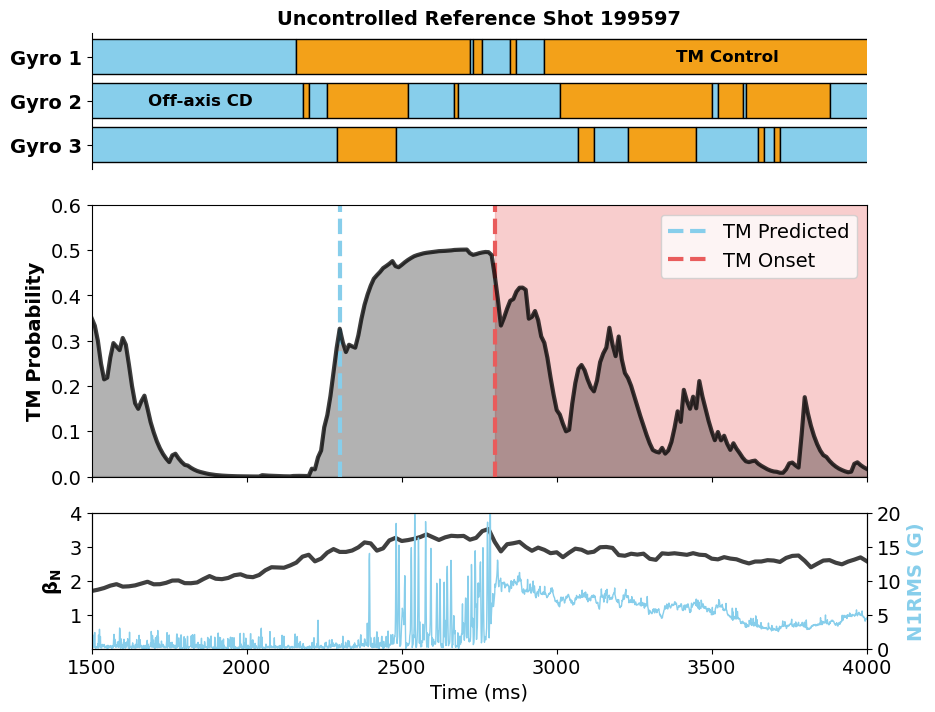

In [136]:
prediction = 2400
onset = 2850

with open('figure_data/199597_rms.pkl', 'rb') as f:
    rms = pickle.load(f)

fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 4, 2]}, figsize=(10, 8))
n1rms = 2
tearability = 1

colors = ['#f3a119', '#87ceeb']
bar_colors = ['#f3a119', '#87ceeb']

heights = [ 400,  470,  240, 1050,  560,   10,   30,   90,   20,   90, 1340, 30,   70,   30,   70,   50,  130,   60,   90,  160,   70]
left = 0
# Create each bar on the same y-position
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(0, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]

left = 0
# [ 310. 2340. 2610. 2740. 2770. 3070. 3080. 3190. 4600. 4610. 4660.]
heights = [ 360.,  540.,  170., 1110.,   20.,   60.,  260.,  150.,   10., 330.,  490.,   20.,   80.,   10.,  270.,  220.,   20., 2000]
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(-1, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]

left = 0
# [ 280. 2390. 2400. 2420. 2450. 2530. 2550. 2570. 2580. 3260. 3960. 4020. 4080. 4130. 4200. 4300. 4370. 4460. 4490. 4540. 4550.]
heights = [ 330.,  670.,   40., 1250.,  190.,  590.,   50.,  110.,  220., 200.,   20.,   30.,   20., 2000]
for i in range(len(heights)):
    if left + heights[i] > 4990:
        heights[i] = 4990 - left
    axs[0].barh(-2, heights[i], left=left, color=bar_colors[i%2], edgecolor='black')
    left += heights[i]
axs[0].set_yticks([0, -1, -2])
axs[0].set_yticklabels(['Gyro 1', 'Gyro 2', 'Gyro 3'], fontweight='bold')

axs[0].text(1850, -1, 'Off-axis CD', ha='center', va='center', fontsize=12, fontweight='bold')
axs[0].text(3550, 0, 'TM Control', ha='center', va='center', fontsize=12, fontweight='bold')


axs[n1rms].plot(rms['betan']['times'], rms['betan']['data'], label=r'$\beta_N$', color='black', alpha=0.75, linewidth=3) # colors[3])
axs[n1rms].set_ylabel(r'$\mathbf{\beta_N}$', color='black', fontweight='bold')
axs[n1rms].set_yticks([1, 2, 3, 4])
axs[n1rms].set_ylim([0, 4])
# axs[n1rms].plot(qmin['times'][:], qmin['199607']['qmin_EFIT02ER'][:], label='qmin', color=colors[0])
# axs[n1rms].legend(loc=(0,0.52))
axs2 = axs[n1rms].twinx()
axs2.plot(rms['N1RMS']['times'], rms['N1RMS']['data'], label='N1RMS', color=colors[1], linewidth=1)
axs2.set_ylabel('N1RMS (G)', color=colors[1], fontweight='bold')
axs2.set_yticks([0, 5, 10, 15, 20])
axs2.set_ylim([0, 20])
axs2.tick_params(axis='y')
axs2.grid(False)

axs[tearability].set_ylabel('TM Probability', fontweight='bold')
#axs[tearability].plot([0,4000], [0.1,0.1], '--', label='Threshold 1', color='#e95c5c', linewidth=3)
#axs[tearability].plot([0,4000], [0.2,0.2], '--', label='Threshold 2', color='#87ceeb', linewidth=3)
#axs[tearability].plot([0,4000], [0.3,0.3], '--', label='Threshold 3', color='#f3a119', linewidth=3)
# make a vertical line at the prediction time
axs[tearability].plot([2300, 2300], [0, 0.6], '--', label='TM Predicted', color='#87ceeb', linewidth=3)
axs[tearability].plot([2800, 2800], [0, 0.6], '--', label='TM Onset', color='#e95c5c', linewidth=3)
# shade the area to the left of this line in red
axs[tearability].fill_between([2800, 4000], 0, 0.6, color='#e95c5c', alpha=0.3)
axs[tearability].plot(rms['TPSSURVIV3']['times'], metrics_helpers.LP_filter(1-rms['TPSSURVIV3']['data']), color='black', linewidth=3, alpha=0.75,) # colors[0])
axs[tearability].fill_between(rms['TPSSURVIV3']['times'], metrics_helpers.LP_filter(1-rms['TPSSURVIV3']['data']), color='black', alpha=0.3) # Fill under the line
axs[tearability].legend(fontsize=14)
# axs[tearability].legend()

#plt.text(1510, 71, 'Gyro 1 Threshold', fontsize=12, fontweight='bold', color='#e95c5c')
#plt.text(1510, 90, 'Gyro 2 Threshold', fontsize=12, fontweight='bold', color='#87ceeb')
#plt.text(1510, 107, 'Gyro 3 Threshold', fontsize=12, fontweight='bold', color='#f3a119')

axs[tearability].set_ylim([0.,0.6])
axs[tearability].set_xlim([1500,4000])
axs[n1rms].set_xlabel('Time (ms)')
axs[0].set_title('Uncontrolled Reference Shot 199597', fontweight='bold', fontsize=14)


#plt.text(1525, 173, '(a)', fontsize=12, fontweight='bold')
#plt.text(1525, 125, '(b)', fontsize=12, fontweight='bold')
#plt.text(1525, 34, '(c)', fontsize=12, fontweight='bold')


axs[0].spines['bottom'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[0].set_xlim([1500,4000])
axs[n1rms].set_xlim([1500,4000])
axs[tearability].set_xlim([1500,4000])
axs2.set_xlim([1500,4000])
axs[0].set_xticks([])
axs2.set_xticks([1500, 2000, 2500, 3000, 3500, 4000])
axs[tearability].set_xticklabels([])

#plt.savefig('plots/199597_experiment.pdf', bbox_inches='tight')

In [44]:
# with open('figure_data/j_eccd_q2.pkl', 'rb') as f:
#     j_eccd_dict = pickle.load(f)
# eccd_time = j_eccd_dict['time']
# eccd_j = j_eccd_dict['JECCD_q=2']
with open('figure_data/jeccd_199606.pkl', 'rb') as f:
    jeccd_199606 = pickle.load(f)
eccd_time = np.arange(2000, 5001, 20)
eccd_j = jeccd_199606
with open('figure_data/complete_shap_dict_2_model23.pkl', 'rb') as f:
    complete_shap_dict = pickle.load(f)

shap_values = complete_shap_dict['shap_values']
model_output = complete_shap_dict['model_output']
x = complete_shap_dict['x']
shots_list = complete_shap_dict['shots_list']
times_list = complete_shap_dict['times_list']
x_filtered = complete_shap_dict['denormalized_x_filtered']
shap_values_filtered = complete_shap_dict['shap_values_filtered']

In [4]:
import copy
shap_values_filtered = copy.deepcopy(shap_values.values)
for i in range(shap_values_filtered.shape[1]):
    shap_values_filtered[:, i] = metrics_helpers.LP_filter(shap_values.values[:, i], alpha=0.64)
denormalized_x_filtered = copy.deepcopy(x)
for i in range(denormalized_x_filtered.shape[1]):
    denormalized_x_filtered[:, i] = metrics_helpers.LP_filter(denormalized_x_filtered[:, i], alpha=0.64)

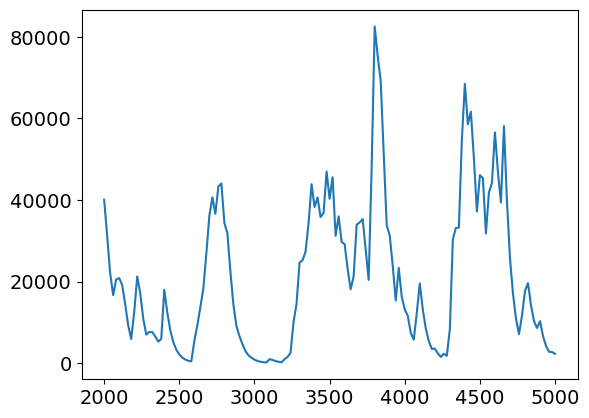

In [43]:
with open('figure_data/jeccd_199606.pkl', 'rb') as f:
    jeccd_199606 = pickle.load(f)
plt.plot(np.arange(2000, 5001, 20), metrics_helpers.LP_filter(jeccd_199606, 0.64))

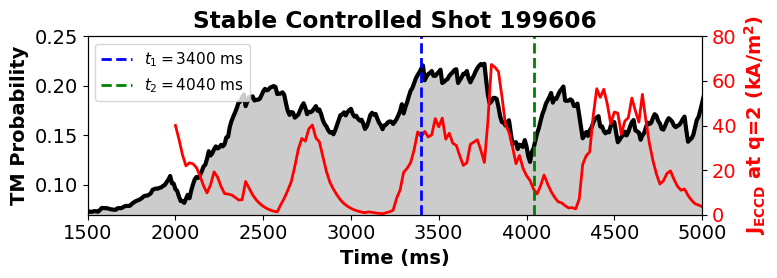

In [58]:
wanted_shot = '199606'

start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

# Low-pass filter for the main line (reuse your function):
filtered_model_output = metrics_helpers.LP_filter(model_output[start_index:end_index], alpha=0.9)

# Example second-data array (replace with your actual data):
second_data = metrics_helpers.LP_filter(eccd_j, alpha=0.75)

fig, ax = plt.subplots(figsize=(8, 3))
# set general fontsize
plt.rcParams.update({'font.size': 14})
# --- Left Y-axis (ax) ---
ax.plot(
    times_list[start_index:end_index], 
    filtered_model_output, 
    color='black', 
    linewidth=3,
    label='TM Probability'
)
ax.fill_between(
    times_list[start_index:end_index],
    filtered_model_output[:, 0], 
    color='gray', 
    alpha=0.4
)

# Labeling and limits for the left axis
ax.set_xlabel('Time (ms)', fontweight='bold')
ax.set_ylabel('TM Probability', fontweight='bold')
ax.set_xlim(1500, 5000)
ax.set_ylim(0.07, 0.25)
ax.set_title(f'Stable Controlled Shot {wanted_shot}', fontweight='bold')

# --- Right Y-axis (ax2) ---
ax2 = ax.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(
    eccd_time, 
    second_data/1000, 
    color='red', 
    linewidth=2, 
)
ax2.set_ylim(0, 80)
# Labeling and limits for the right axis
#ax2.set_ylabel('J$\mathbf{_{ECCD}}$ at q=2 (kA/m$\mathbf{^2}$)', color='#e95c5c', fontweight='bold')
#ax2.tick_params(axis='y', labelcolor='#e95c5c')
ax2.set_ylabel('J$\mathbf{_{ECCD}}$ at q=2 (kA/m$\mathbf{^2}$)', color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
# e.g., set your own y-limits here:
# ax2.set_ylim(0, 1.0)
ind1 = 340
ind2 = 404


time_indices = [ind1, ind2]
colors = ['blue', 'green']
for n, ind in enumerate(time_indices):
    plt.axvline(x=times_list[start_index:end_index][ind], color = colors[n], linestyle='--', linewidth=2, label=rf'$t_{n+1} = {times_list[start_index:end_index][ind]:.4g}$ ms')
plt.legend(loc='upper left', fontsize='11')
plt.tight_layout()
plt.savefig('plots/199606_survival.pdf', bbox_inches='tight')
plt.show()


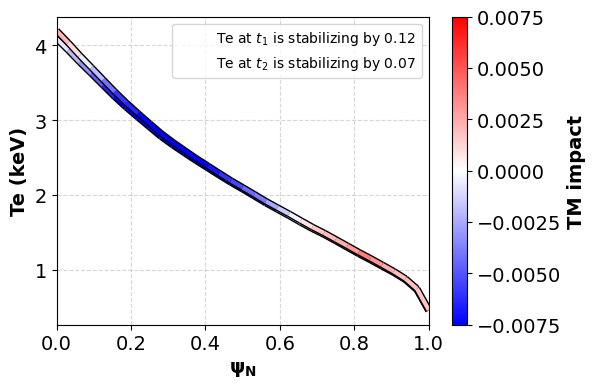

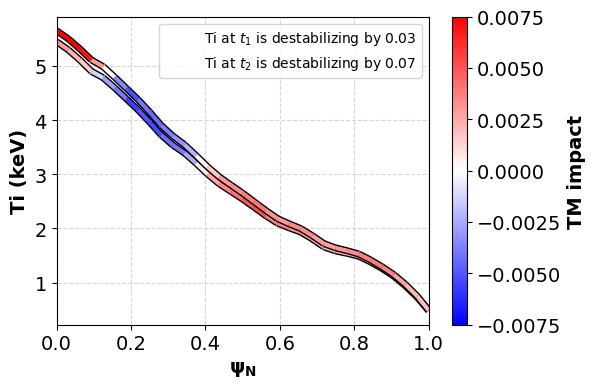

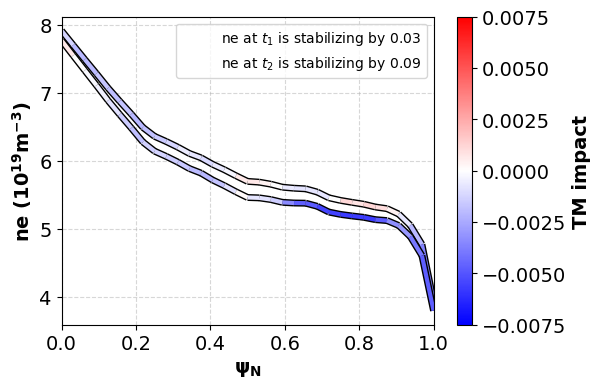

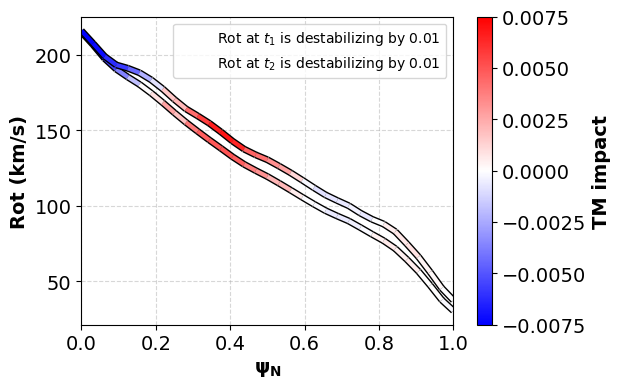

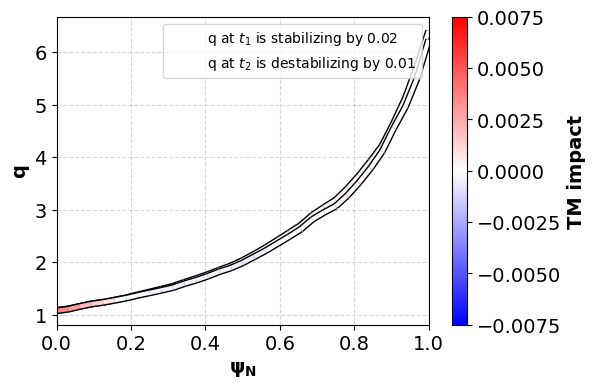

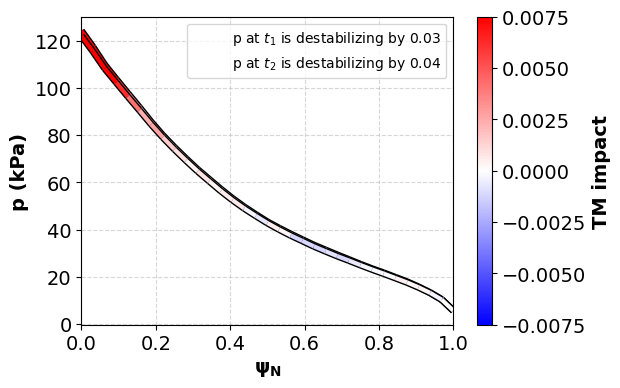

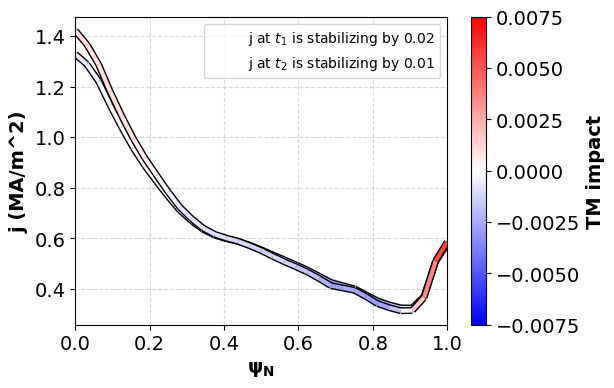

In [34]:
ind1 = 340
ind2 = 404

time_indices = [ind1, ind2]
new_prof_signals = ['Te', 'Ti', 'ne', 'Vtor', 'q', 'p', 'j']
short_prof_names = ['Te', 'Ti', 'ne', 'Rot', 'q', 'p', 'j']
new_prof_signals_fullname = ['Te (keV)', 'Ti (keV)', r'ne ($\mathbf{10^{19} m^{-3}}$)', 'Rot (km/s)', 'q', 'p (kPa)', 'j (MA/m^2)']
for i in range(len(new_prof_signals)):
    plotting_helpers.plot_2_profiles_heatmaps(np.linspace(0, 1, 33), i, new_prof_signals_fullname, short_prof_names, x_filtered[start_index:end_index, :], shap_values_filtered[start_index:end_index], time_indices, title='', averaging_window_size = 7, save_name=f"{wanted_shot}_shap_{new_prof_signals[i]}_nolabel")


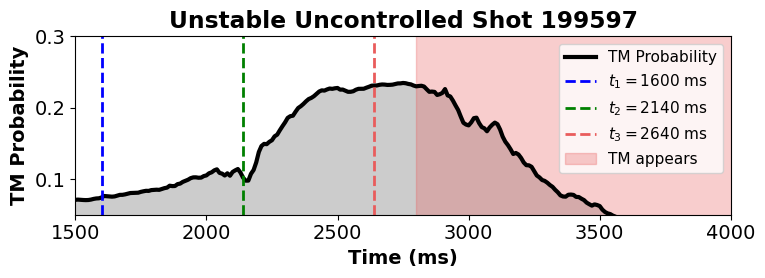

In [62]:
wanted_shot = '199597'

start_index = np.where(shots_list == wanted_shot)[0][0]
end_index = len(shots_list) - 1 - np.where(shots_list[::-1] == wanted_shot)[0][0]

# Low-pass filter for the main line (reuse your function):
filtered_model_output = metrics_helpers.LP_filter(model_output[start_index:end_index], alpha=0.9)

# Example second-data array (replace with your actual data):
second_data = eccd_j

fig, ax = plt.subplots(figsize=(8, 3))
# set general fontsize
plt.rcParams.update({'font.size': 14})
# --- Left Y-axis (ax) ---
ax.plot(
    times_list[start_index:end_index], 
    filtered_model_output, 
    color='black', 
    linewidth=3,
    label='TM Probability'
)
ax.fill_between(
    times_list[start_index:end_index],
    filtered_model_output[:, 0], 
    color='gray', 
    alpha=0.4
)

# Labeling and limits for the left axis
ax.set_xlabel('Time (ms)', fontweight='bold')
ax.set_ylabel('TM Probability', fontweight='bold')
ax.set_xlim(1500, 4000)
ax.set_ylim(0.05, 0.3)
ax.set_title(f'Unstable Uncontrolled Shot {wanted_shot}', fontweight='bold')

ind1 = 160
ind2 = 214
ind3 = 264

new_prof_signals = ['Te', 'Ti', 'ne', 'Vtor', 'q', 'p', 'j']
time_indices = [ind1, ind2, ind3]
colors = ['blue', 'green', '#e95c5c']
for n, ind in enumerate(time_indices):
    plt.axvline(x=times_list[start_index:end_index][ind], color = colors[n], linestyle='--', linewidth=2, label=rf'$t_{n+1} = {times_list[start_index:end_index][ind]:.4g}$ ms')
# shade the area to the left of this line in red
plt.fill_between([2800, 5000], 0, 0.5, color='#e95c5c', alpha=0.3, label='TM appears')
plt.legend(loc='upper right', fontsize='11')
plt.tight_layout()
plt.savefig('plots/survival_199597_2.pdf', bbox_inches='tight')
plt.show()


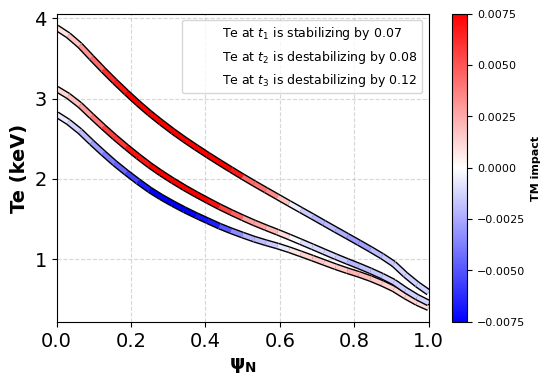

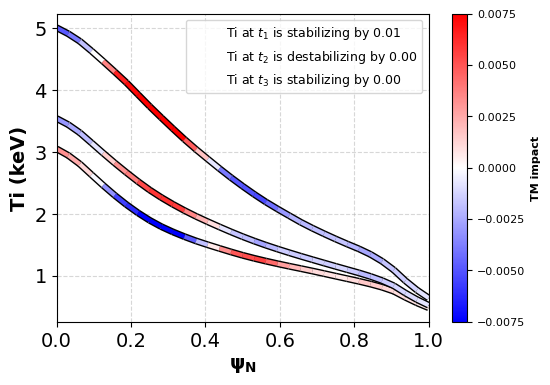

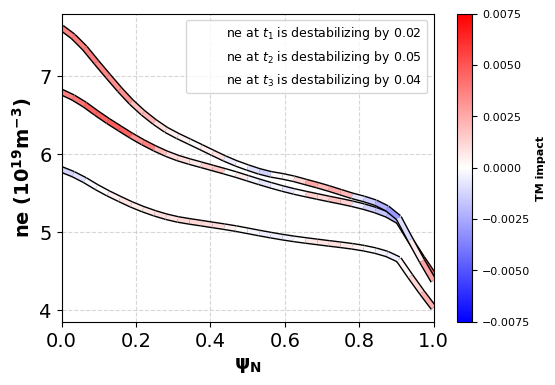

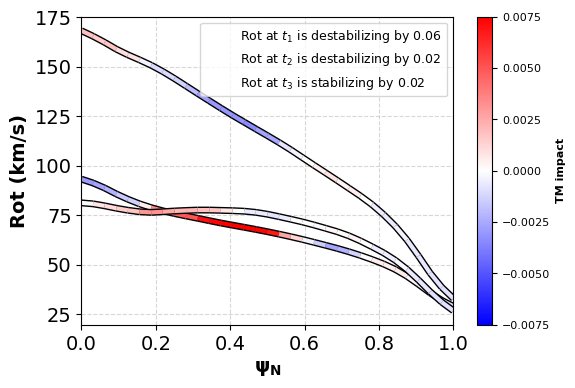

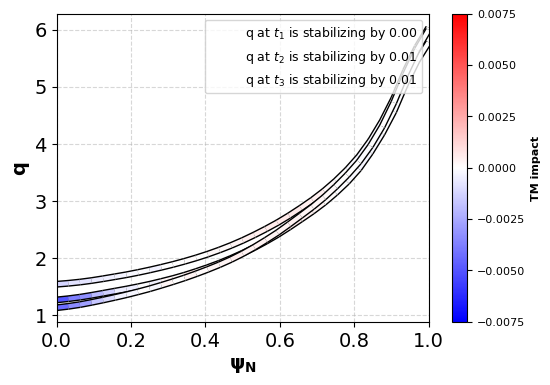

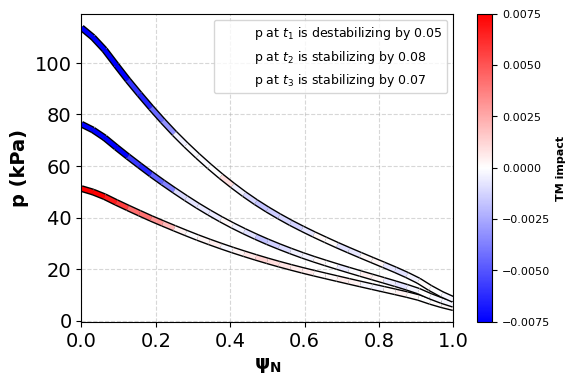

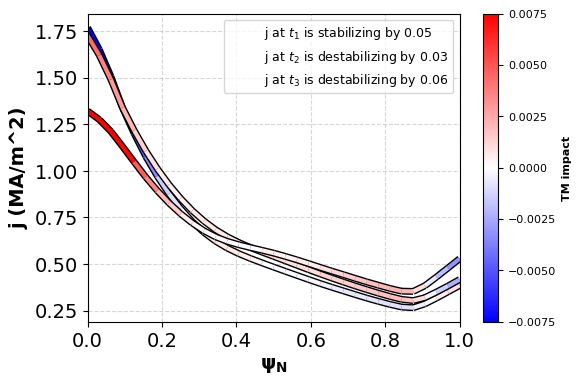

In [72]:
new_prof_signals = ['Te', 'Ti', 'ne', 'Vtor', 'q', 'p', 'j']
short_prof_names = ['Te', 'Ti', 'ne', 'Rot', 'q', 'p', 'j']
new_prof_signals_fullname = ['Te (keV)', 'Ti (keV)', r'ne ($\mathbf{10^{19} m^{-3}}$)', 'Rot (km/s)', 'q', 'p (kPa)', 'j (MA/m^2)']
#for i in range(len(new_prof_signals)):
for i in [0,1,2,3,4,5,6]:
    #plotting_helpers.plot_3_profiles_heatmaps(np.linspace(0, 1, 33), i, new_prof_signals_fullname, short_prof_names, x_filtered[start_index:end_index, :], shap_values_filtered[start_index:end_index], time_indices, averaging_window_size = 7, save_name=f"{wanted_shot}_shap_{new_prof_signals[i]}")
    plotting_helpers.plot_3_profiles_heatmaps(np.linspace(0, 1, 33), i, new_prof_signals_fullname, short_prof_names, x_filtered[start_index:end_index, :], shap_values_filtered[start_index:end_index], time_indices, averaging_window_size = 7, save_name=f"{wanted_shot}_shap_{new_prof_signals[i]}_nolabel")

dict_keys(['tpssurvive', 'tpssurviv3', 'tpssurviv4', 'tpspinj', 'tpstinj', 'tpsbetan', 'tpsqmin', 'tpsech', 'tpsip', 'tpsbt', 'tpsli', 'tpsaminor', 'tpsrmaxis', 'tpstribot', 'tpstritop', 'tpskappa', 'tpsvolume', 'tpste1', 'tpsti1', 'tpsne1', 'tpsrot1', 'tpsiota1', 'tpsp1', 'tpscte1', 'tpscti1', 'tpscne1', 'tpscrot1', 'tpsciota1', 'tpscp1', 'tpsccurr1', 'tpste2', 'tpsti2', 'tpsne2', 'tpsrot2', 'tpsiota2', 'tpsp2', 'tpscte2', 'tpscti2', 'tpscne2', 'tpscrot2', 'tpsciota2', 'tpscp2', 'tpsccurr2', 'tpste3', 'tpsti3', 'tpsne3', 'tpsrot3', 'tpsiota3', 'tpsp3', 'tpscte3', 'tpscti3', 'tpscne3', 'tpscrot3', 'tpsciota3', 'tpscp3', 'tpsccurr3', 'tpste4', 'tpsti4', 'tpsne4', 'tpsrot4', 'tpsiota4', 'tpsp4', 'tpscte4', 'tpscti4', 'tpscne4', 'tpscrot4', 'tpsciota4', 'tpscp4', 'tpsccurr4'])


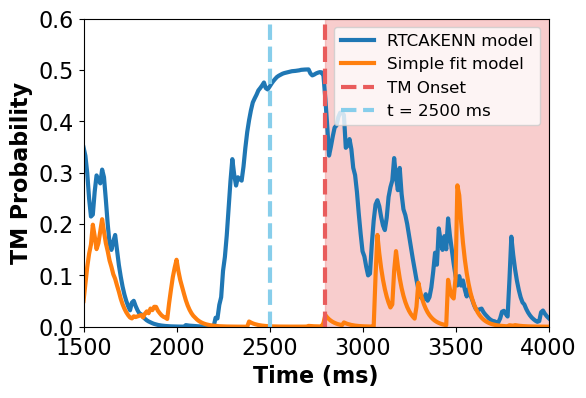

In [139]:
from sklearn.decomposition import PCA
with open('/projects/EKOLEMEN/survival_tm_2/data/high_qmin_survival_ptdata.pkl', 'rb') as f:
    ptdata = pickle.load(f)
with open('/projects/EKOLEMEN/survival_tm_2/data/cake_normalizations_dict.pkl', 'rb') as f:
    cakenn_normalizations = pickle.load(f)
with open('/projects/EKOLEMEN/survival_tm_2/data/rt_normalizations_dict.pkl', 'rb') as f:
    rt_normalizations = pickle.load(f)

print(ptdata['199597'].keys())
plt.figure(figsize=(6, 4))
plt.xlim(1500, 4000)
# set the size of the figure
#plt.figure(figsize=(8, 6))

plt.plot(ptdata['199597']['tpssurvive']['times'], metrics_helpers.LP_filter(1-ptdata['199597']['tpssurviv3']['data'], 0.8), label='RTCAKENN model', linewidth=3)
plt.plot(ptdata['199597']['tpssurvive']['times'],metrics_helpers.LP_filter(1-ptdata['199597']['tpssurviv4']['data'], 0.8), label='Simple fit model', linewidth=3)
plt.ylabel('TM Probability', fontweight='bold')
plt.xlabel('Time (ms)', fontweight='bold')
plt.ylim(0, 0.6)
plt.plot([2800, 2800], [0, 0.6], '--', label='TM Onset', color='#e95c5c', linewidth=3)
plt.plot([2500, 2500], [0, 0.6], '--', label='t = 2500 ms', color='#87ceeb', linewidth=3)
# shade the area to the left of this line in red
plt.fill_between([2800, 4000], 0, 0.6, color='#e95c5c', alpha=0.3)
#plt.plot(ptdata['199597']['tpssurvive']['times'], 1-ptdata['199597']['tpssurviv4']['data'], label='Simple fit inputs')
#plt.plot(ptdata['199597']['tpssurvive']['times'], 1-ptdata['199597']['tpssurviv3']['data'], label='RTCAKENN inputs')
plt.legend(fontsize=12)

plt.rcParams.update({'font.size': 16})
plt.savefig('plots/tm_probability_comparison.pdf', bbox_inches='tight')



[  0.           9.99999997  19.99999995  29.99999992  39.9999999
  49.99999987  59.99999985  69.99999982  79.9999998   89.99999977
  99.99999975 109.99999972 119.9999997  129.99999967 139.99999965
 149.99999962 159.9999996  169.99999957 179.99999955 189.99999952
 199.9999995  209.99999947 219.99999944 229.99999942 239.99999939
 249.99999937 259.99999934 269.99999932 279.99999929 289.99999927]
(6611, 861)


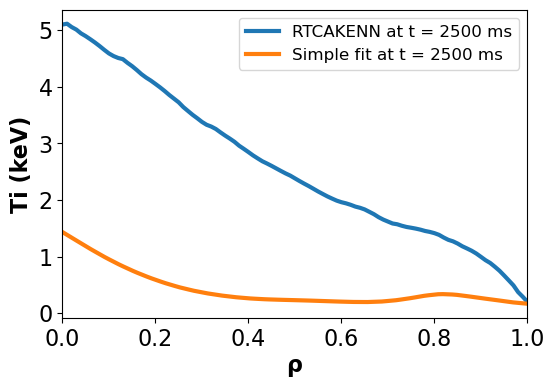

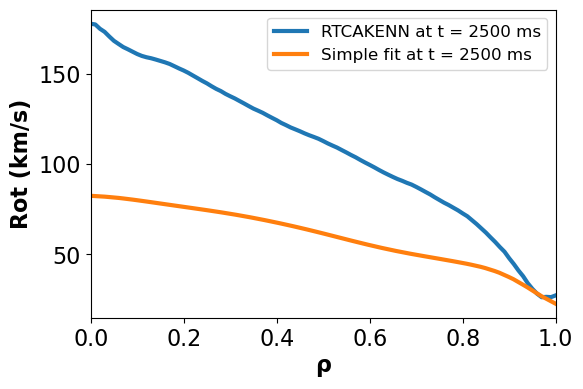

In [138]:
with open('/projects/EKOLEMEN/survival_tm_2/data/scenario0_ptdata_dict.pkl', 'rb') as f:
    scenario0_ptdata_dict = pickle.load(f)
with open('/projects/EKOLEMEN/survival_tm_2/data/scenario0_rtprofiles_ptdata_dict.pkl', 'rb') as f:
    scenario0_ptdata_rtprofiles_dict = pickle.load(f)
cakenn_pt_profiles = scenario0_ptdata_dict['x_unnormed']
rt_pt_profiles = scenario0_ptdata_rtprofiles_dict['x_unnormed']
print(scenario0_ptdata_dict['times_list'][:30])
print(cakenn_pt_profiles.shape)
i = 1
t = 250
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, 1, 101), cakenn_pt_profiles[t, 14 + i*121:14+i*121+101], label='RTCAKENN at t = 2500 ms', linewidth=3)
plt.plot(np.linspace(0, 1, 100), -rt_pt_profiles[t, 14+i*100:14+(i+1)*100]/1000, label='Simple fit at t = 2500 ms', linewidth=3)
plt.ylabel(new_prof_signals_fullname[i], fontweight='bold')
plt.xlabel(r'$\mathbf{\rho}$')
plt.xlim(0, 1)
plt.legend(fontsize=12)
plt.rcParams.update({'font.size': 16})
plt.savefig('plots/Ti_profiles.pdf', bbox_inches='tight')
plt.show()

i = 3
t = 250
plt.figure(figsize=(6, 4))
plt.plot(np.linspace(0, 1, 101), cakenn_pt_profiles[t, 14 + i*121:14+i*121+101], label='RTCAKENN at t = 2500 ms', linewidth=3)
plt.plot(np.linspace(0, 1, 100), -rt_pt_profiles[t, 14+i*100:14+(i+1)*100]/1000, label='Simple fit at t = 2500 ms', linewidth=3)
plt.ylabel(new_prof_signals_fullname[i], fontweight='bold')
plt.xlabel(r'$\mathbf{\rho}$')
plt.xlim(0, 1)
plt.legend(fontsize=12)
plt.rcParams.update({'font.size': 16})
plt.savefig('plots/Rot_profiles.pdf', bbox_inches='tight')
plt.show()